In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import argparse
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [2]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*4)])
    except RuntimeError as e:
        print(e)

In [3]:
def load_pep_and_codify(file, max_len):
    aa_dict={'A':1,'R':2,'N':3,'D':4,'C':5,'Q':6,'E':7,'G':8,'H':9,'I':10,'L':11,'K':12,'M':13,'F':14,
        'P':15,'O':16,'S':17,'U':18,'T':19,'W':20,'Y':21,'V':22}
    with open(file, 'r') as inf:
        lines = inf.read().splitlines()
    pep_codes=[]
    long_pep_counter = 0
    newLines = []
    for pep in lines:
        if not len(pep) > max_len:
            current_pep=[]
            for aa in pep:
                current_pep.append(aa_dict[aa])
            pep_codes.append(current_pep)
            newLines.extend([pep])
        else:
            long_pep_counter += 1
    predict_data = keras.preprocessing.sequence.pad_sequences(pep_codes, value=0, padding='post', maxlen=max_len)
    return predict_data, long_pep_counter, newLines

# New Train

In [23]:
pep = tf.keras.layers.Input(shape=((30,)))
input1_ = tf.keras.layers.Embedding(23, 32, input_length=30, mask_zero=True)(pep)
input1 = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(input1_)

reshap = keras.backend.reshape(input1, [-1, 30, 32, 1])

cnn1 = tf.keras.layers.TimeDistributed(
    tf.keras.layers.Conv1D(
        filters=16, kernel_size=3, strides=1, padding='same')
    )(reshap)

avgpool = tf.keras.layers.TimeDistributed(
    tf.keras.layers.AveragePooling1D(pool_size=2)
    )(cnn1)

flat = tf.keras.layers.TimeDistributed(
    tf.keras.layers.Flatten()
    )(avgpool)

lstm = tf.keras.layers.LSTM(64)(flat)
    
# den = tf.keras.layers.Dense(16, activation='relu')(lstm)
# dropout1 = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(den)
output = tf.keras.layers.Dense(1, activation='sigmoid')(lstm)

model = tf.keras.Model(inputs=pep, outputs=[output])
model.summary()

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                      mode='min', 
                                      verbose=1,
                                      patience=20)

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 30)]              0         
_________________________________________________________________
embedding_11 (Embedding)     (None, 30, 32)            736       
_________________________________________________________________
dropout_12 (Dropout)         (None, 30, 32)            0         
_________________________________________________________________
tf.reshape_11 (TFOpLambda)   (None, 30, 32, 1)         0         
_________________________________________________________________
time_distributed_33 (TimeDis (None, 30, 32, 16)        64        
_________________________________________________________________
time_distributed_34 (TimeDis (None, 30, 16, 16)        0         
_________________________________________________________________
time_distributed_35 (TimeDis (None, 30, 256)           0  

# 1. Make Data X_train, y_train, X_test, y_test

In [24]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

file_path = 'compareModel/2019Bioinformatics_DeepMSPeptide/DeepMSPeptide/'

In [11]:
# make DeepMSpeptide format
df_peptide_train = pd.read_csv('data/df_detect_peptide_train.csv')
df_peptide_test = pd.read_csv('data/df_detect_peptide_test.csv')

inp = open(file_path+'detect_peptide_train.txt', 'w')
inp_y = open(file_path+'detect_peptide_train_y.txt', 'w')
for x, y in df_peptide_train[['PEP', 'ID']].values:
    inp.write(x+'\n')
    inp_y.write(str(y)+'\n')
inp.close()
inp_y.close()

inp = open(file_path+'detect_peptide_test.txt', 'w')
inp_y = open(file_path+'detect_peptide_test_y.txt', 'w')
for x, y in df_peptide_test[['PEP', 'ID']].values:
    inp.write(x+'\n')
    inp_y.write(str(y)+'\n')
inp.close()
inp_y.close()

args = file_path + 'detect_peptide_train.txt'
print('Loading input peptides')
X_train, skipped, lines = load_pep_and_codify(args, 30)
tmp = open(file_path+'detect_peptide_train_y.txt')
y_train = np.array([int(_.replace('\n', '')) for _ in tmp.readlines()])
tmp.close()
print('Succesfully loaded {0} peptides and skipped {1}'.format(len(lines), str(skipped)))

args = file_path + 'detect_peptide_test.txt'
print('Loading input peptides')
X_test, skipped, lines = load_pep_and_codify(args, 30)
tmp = open(file_path+'detect_peptide_test_y.txt')
y_test = np.array([int(_.replace('\n', '')) for _ in tmp.readlines()])
tmp.close()
print('Succesfully loaded {0} peptides and skipped {1}'.format(len(lines), str(skipped)))

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)


Loading input peptides
Succesfully loaded 679396 peptides and skipped 0
Loading input peptides
Succesfully loaded 133992 peptides and skipped 0
(543516, 30) (135880, 30) (133992, 30) (543516,) (135880,) (133992,)


# 2. train

In [12]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

In [25]:
history = model.fit(X_train, y_train, epochs=200, 
                    batch_size=100,
                    validation_data=(X_val, y_val),
                                       callbacks=[es])

Epoch 1/200
5436/5436 [==============================] - 27s 5ms/step - loss: 0.5512 - accuracy: 0.7081 - val_loss: 0.4852 - val_accuracy: 0.7660
Epoch 2/200
5436/5436 [==============================] - 25s 5ms/step - loss: 0.4737 - accuracy: 0.7744 - val_loss: 0.4599 - val_accuracy: 0.7826
Epoch 3/200
5436/5436 [==============================] - 25s 5ms/step - loss: 0.4592 - accuracy: 0.7828 - val_loss: 0.4490 - val_accuracy: 0.7900
Epoch 4/200
5436/5436 [==============================] - 25s 5ms/step - loss: 0.4489 - accuracy: 0.7899 - val_loss: 0.4416 - val_accuracy: 0.7954
Epoch 5/200
5436/5436 [==============================] - 25s 5ms/step - loss: 0.4417 - accuracy: 0.7946 - val_loss: 0.4348 - val_accuracy: 0.8006
Epoch 6/200
5436/5436 [==============================] - 25s 5ms/step - loss: 0.4350 - accuracy: 0.7987 - val_loss: 0.4368 - val_accuracy: 0.8004
Epoch 7/200
5436/5436 [==============================] - 26s 5ms/step - loss: 0.4308 - accuracy: 0.8022 - val_loss: 0.4338 -

5436/5436 [==============================] - 78s 14ms/step - loss: 0.3893 - accuracy: 0.8247 - val_loss: 0.3949 - val_accuracy: 0.8223
Epoch 57/200
5436/5436 [==============================] - 77s 14ms/step - loss: 0.3897 - accuracy: 0.8250 - val_loss: 0.3936 - val_accuracy: 0.8233
Epoch 58/200
5436/5436 [==============================] - 76s 14ms/step - loss: 0.3900 - accuracy: 0.8244 - val_loss: 0.3935 - val_accuracy: 0.8233
Epoch 59/200
5436/5436 [==============================] - 78s 14ms/step - loss: 0.3878 - accuracy: 0.8258 - val_loss: 0.3948 - val_accuracy: 0.8218
Epoch 60/200
5436/5436 [==============================] - 78s 14ms/step - loss: 0.3892 - accuracy: 0.8255 - val_loss: 0.3936 - val_accuracy: 0.8225
Epoch 61/200
5436/5436 [==============================] - 77s 14ms/step - loss: 0.3886 - accuracy: 0.8250 - val_loss: 0.3924 - val_accuracy: 0.8231
Epoch 62/200
5436/5436 [==============================] - 77s 14ms/step - loss: 0.3886 - accuracy: 0.8250 - val_loss: 0.3928 

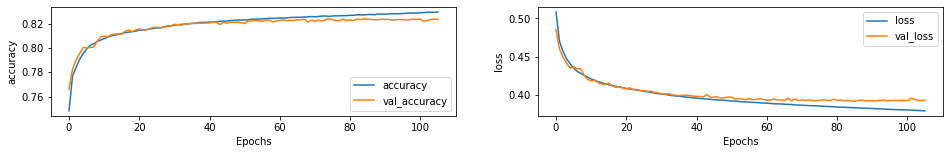

In [26]:
plt.figure(figsize=(16,2))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.subplot(1,2,2)
plot_graphs(history, 'loss')

# 3. test

In [27]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import seaborn as sns

In [28]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

4188/4188 [==============================] - 60s 14ms/step - loss: 0.3837 - accuracy: 0.8283
Test Loss: 0.38369375467300415
Test Accuracy: 0.828340470790863


              precision    recall  f1-score   support

           0       0.86      0.78      0.82     66996
           1       0.80      0.88      0.84     66996

    accuracy                           0.83    133992
   macro avg       0.83      0.83      0.83    133992
weighted avg       0.83      0.83      0.83    133992

rf auc : 0.9106773293556911


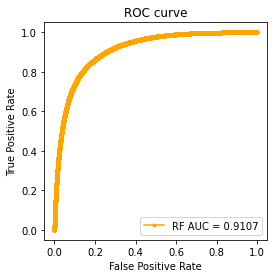

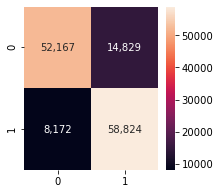

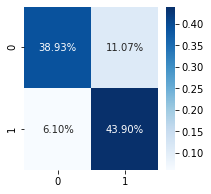

In [29]:
# prediction
y_pred = [1 if i>=0.5 else 0 for i in model.predict(X_test)]
print(classification_report(y_test, y_pred))
# AUC
probs = model.predict(X_test)
rf_auc = roc_auc_score(y_test, probs)
print('rf auc : {}'.format(rf_auc))
# plot the roc curve for the model
rf_fpr, rf_tpr, _ = roc_curve(y_test, probs)
plt.figure(figsize=(4, 4))
plt.plot(rf_fpr, rf_tpr, marker='.', label='RF AUC = {:.4f}'.format(rf_auc), color='orange')
plt.title('ROC curve')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

cf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
plt.show()